In [1]:
PHOSPHOSTY_FILE = r'Phospho (STY)Sites.txt'
DESIGN_FILE = r'design-phospho.csv'
MINIMUM_VALID_VALUES_PER_GROUP = 7

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import numpy as np
import pandas as pd
import padua
import padua.visualize as viz

In [3]:
SOURCE_FOLDER = os.path.dirname(PHOSPHOSTY_FILE)
BASENAME = os.path.splitext(os.path.basename(PHOSPHOSTY_FILE))[0]

SOURCE_FOLDER = os.path.dirname(PHOSPHOSTY_FILE)
df = padua.io.read_maxquant(PHOSPHOSTY_FILE)
df = padua.filters.remove_reverse(df)
df = padua.filters.remove_potential_contaminants(df)

/Users/e.bosdriesz/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (1545,1546,5008,5009,5011,5012) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


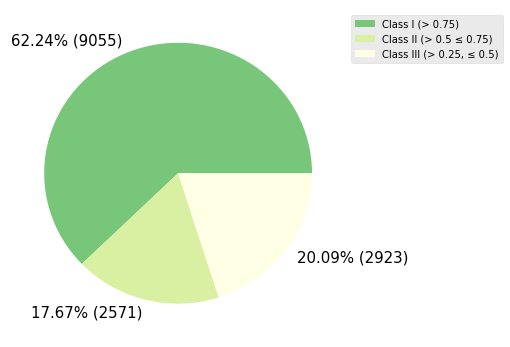

In [5]:
ax = viz.modificationlocalization(df)
#ax.figure.savefig( os.path.join(SOURCE_FOLDER,  BASENAME + '-modification_localisation.png'), bbox_inches='tight' )

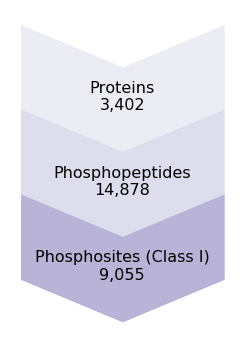

In [6]:
ax = viz.sitespeptidesproteins(df, labels=['Phosphosites (Class I)','Phosphopeptides','Proteins'])
#ax.figure.savefig( os.path.join(SOURCE_FOLDER, BASENAME + '-sitespeptidesproteins.png') )

In [7]:
df = padua.filters.filter_localization_probability(df)

/Users/e.bosdriesz/anaconda/lib/python3.5/site-packages/padua/visualize.py:640: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  df.sort(axis=1, inplace=True)


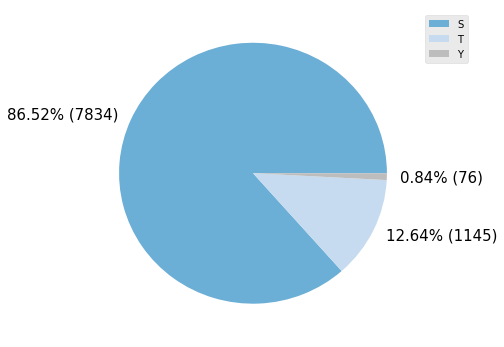

In [8]:
ax = viz.modifiedaminoacids(df)
#ax.figure.savefig( os.path.join(SOURCE_FOLDER,  BASENAME + '-modification_amino_acids.png'), bbox_inches='tight' )

In [9]:
# Drop the non__N columns from phospho data
dft = df.filter(regex="^(?!Intensity).*$")
dfi = df.filter(regex='^Intensity.*IMAC.*__\d')
df = pd.concat([dft,dfi], axis=1)

df = padua.process.transform_expression_columns(df, np.log2)
df = padua.process.expand_side_table(df)

df = padua.normalization.subtract_column_median(df)

/Users/e.bosdriesz/anaconda/lib/python3.5/site-packages/padua/process.py:319: RuntimeWarning: divide by zero encountered in log2
  df.iloc[:, mask] = fn(df.iloc[:, mask])


In [13]:

# ax = viz.rankintensity(df)
#ax.figure.savefig( os.path.join(SOURCE_FOLDER,  BASENAME + '-rank-intensity.png'), bbox_inches='tight' )

In [14]:
df = df.reset_index()
df = df.filter(regex='^(Intensity .*|Amino acid|Protein names|Gene names|Multiplicity|Proteins|Positions within proteins|id).*$')
#df.set_index(['Proteins','Protein names','Gene names','Positions within proteins','Amino acid','Multiplicity','id'], inplace=True)

In [15]:
design = pd.read_csv(DESIGN_FILE)
df = padua.process.build_index_from_design(df, design, remove=['Intensity '], types={'Timepoint':int, 'Replicate': int, 'Technical': float})

/Users/e.bosdriesz/anaconda/lib/python3.5/site-packages/padua/process.py:56: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  design = design.convert_objects(convert_numeric=True)


In [16]:
df[ ~np.isfinite(df) ] = np.nan

In [17]:
# Remove technical replicate/reinjections by taking median along that axis
df = df.median(axis=1, level=[0,1,2])

In [18]:
df = padua.filters.minimum_valid_values_in_any_group(df, levels=[0], n=MINIMUM_VALID_VALUES_PER_GROUP, invalid=np.nan)

In [19]:
# Subtract column median
md = np.nanmedian(df.values, axis=0)
df = df-md

In [29]:
df.to_csv( os.path.join(SOURCE_FOLDER,  BASENAME + '-processed.csv'))
df.to_pickle( os.path.join(SOURCE_FOLDER,  BASENAME + '-processed.pickle'))

In [30]:
df_r = df.copy()
df_r.columns = ['.'.join([str(s) for s in v]) for v in df_r.columns.values]
df_r.index = ['@'.join([str(s) for s in v]) for v in df_r.index.values]
df_r.to_csv(os.path.join(SOURCE_FOLDER,  BASENAME + '-processed-r.csv'))

# Phosphoenrichment

Calculate the enrichment of modified peptides by supplying the modificationSpecificPeptides file.

In [20]:
MODIFICATION_SPECIFIC_PEPTIDES_FILE = os.path.join(os.path.dirname(PHOSPHOSTY_FILE), 'modificationSpecificPeptides.txt')

/Users/e.bosdriesz/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (1175,1176,1183) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/e.bosdriesz/anaconda/lib/python3.5/site-packages/padua/process.py:56: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  design = design.convert_objects(convert_numeric=True)
/Users/e.bosdriesz/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


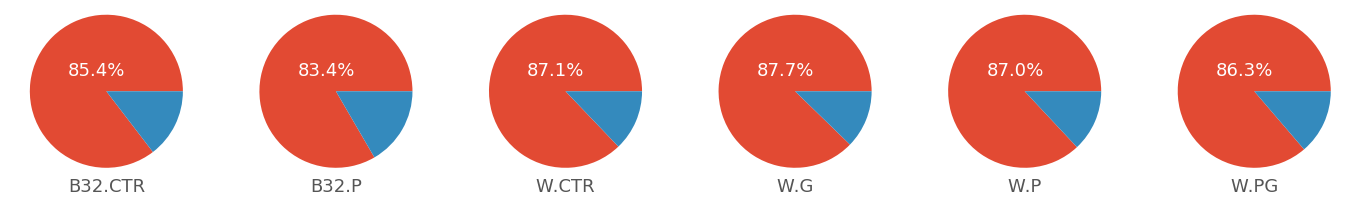

In [21]:
dfmsp = padua.io.read_maxquant(MODIFICATION_SPECIFIC_PEPTIDES_FILE)
dfr = padua.analysis.enrichment_from_msp(dfmsp)
dfr = padua.process.build_index_from_design(dfr, design, remove=['Intensity '])

ax = viz.enrichment(dfr.mean(axis=1, level=[0]))[0].figure.savefig( os.path.join(SOURCE_FOLDER, BASENAME + '-phosphoenrichment-group-mean.svg'), bbox_inches='tight' )

In [24]:
# ax = viz.sitespeptidesproteins(df, labels=['Phosphosites (Class I)','Phosphopeptides','Proteins'])